In [ ]:
#House Pricing Kaggle Cometition

In [57]:
#Linear Algebra
import numpy as np

#Data Manipulation and Visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Statistics
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p

#Modeling
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import learning_curve
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

In [2]:
#Load in data
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')

train_len = len(train_df)

Resulting_Id = test_df['Id']

In [3]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train_df['SalePrice'].isnull().sum()

0

In [5]:
#Drop the ID column from train and test sets
train_df = train_df.drop('Id', axis = 1)
test_df = test_df.drop('Id', axis = 1)

In [6]:
#Check for outlier based on documentation

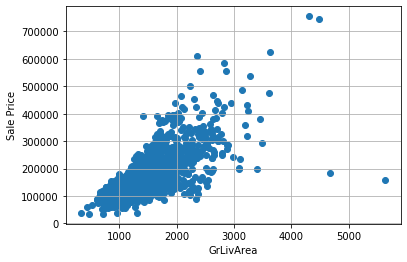

In [7]:
fig, ax = plt.subplots()
ax = ax.scatter(x = train_df['GrLivArea'], y = train_df['SalePrice'])
plt.xlabel('GrLivArea')
plt.ylabel('Sale Price')
plt.grid()

We can see that the bottom left quadrant has some outliers let's drop those 

In [8]:
train_df = train_df.drop(train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 200000)].index)
train_df.shape

(1458, 80)

In [9]:
train_len = len(train_df)

<h3> Let's check the distribution plot for our target features Sale Price </h3>


 Mu: 180932.92, Sigma: 79467.79



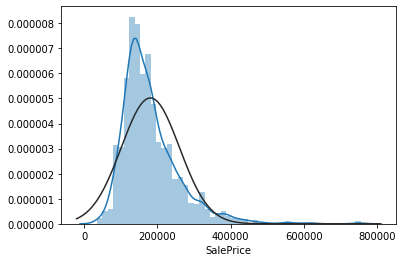

In [10]:
sp_dist = sns.distplot(train_df['SalePrice'], fit = norm)
sp_dist

#Plot Mu, Sigma
mu, sigma = norm.fit(train_df['SalePrice'])
print('\n Mu: {:.2f}, Sigma: {:.2f}\n'.format(mu, sigma))

Clearly a right skewed plot so now we need to change this to be more normally distributed since we are dealing with linearity

Mu: 12.02, Sigma: 0.40


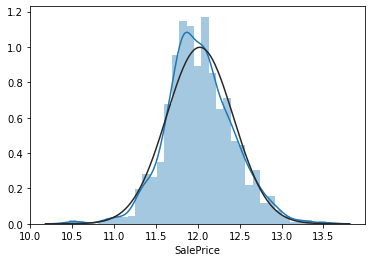

In [11]:
#Normal distribution using log1p
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

#Plot to check distribution
norm_plot = sns.distplot(train_df['SalePrice'], fit = norm)
norm_plot

#Get Mu, Sigma
mu, sigma = norm.fit(train_df['SalePrice'])
print('Mu: {:.2f}, Sigma: {:.2f}'.format(mu, sigma))

Nice we have clearly made sale prices more normally distributed

In [12]:
#Separate our target here and then drop it so it doesn't get messed up in the process
target = train_df['SalePrice']

#Drop
train_df = train_df.drop('SalePrice', axis = 1)

data = pd.concat(objs = [train_df, test_df], sort = False).reset_index(drop=True)
data.shape

(2917, 79)

In [13]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [14]:
#Need to change year sold and month sold to strings because leaving them as ints could skew data 
data['MoSold'] = data['MoSold'].astype(str)
data['YrSold'] = data['YrSold'].astype(str)

data['MSSubClass'] = data['MSSubClass'].astype(str)
data.dtypes

MSSubClass        object
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MiscVal            int64
MoSold            object
YrSold            object
SaleType          object
SaleCondition     object
Length: 79, dtype: object

In [15]:
train_df.shape

(1458, 79)

In [16]:
test_df.shape

(1459, 79)

<h3> Feature Engineering </h3>

In [17]:
#Since we have so many columnns lets see which are categorical and which are numerical

#Numerical Features
num_feats = data.dtypes[data.dtypes != 'object'].index

#Categorical Features 
cat_feats = data.dtypes[data.dtypes == 'object'].index

print('Numerical Features: ', num_feats)
print('Categorical Features: ', cat_feats)

Numerical Features:  Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')
Categorical Features:  Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'He

In [18]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [19]:
data['1stFlrSF'].head()

0     856
1    1262
2     920
3     961
4    1145
Name: 1stFlrSF, dtype: int64

In [20]:
data['2ndFlrSF'].head()

0     854
1       0
2     866
3     756
4    1053
Name: 2ndFlrSF, dtype: int64

In [21]:
data['TotalBsmtSF'].head()

0     856.0
1    1262.0
2     920.0
3     756.0
4    1145.0
Name: TotalBsmtSF, dtype: float64

Total House Square Footage

In [22]:
data['HouseSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,HouseSF
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,2566.0
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,2524.0
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,2706.0
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,2473.0
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,3343.0


<h3> Let's handle the Zoning NaN values and then Alley ones </h3>

In [23]:
data['MSZoning'].value_counts()

RL         2263
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

In [24]:
#Replace Null with the most common zoning
data['MSZoning'] = data['MSZoning'].fillna('RL')
data['MSZoning'].value_counts()

RL         2267
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

In [25]:
data['Alley'].value_counts()

Grvl    120
Pave     78
Name: Alley, dtype: int64

In [26]:
data.isnull().sum() 

MSSubClass         0
MSZoning           0
LotFrontage      486
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
HouseSF            1
Length: 80, dtype: int64

In [27]:
#Fill in Nan's which are really none for categorical features
data['PoolQC'] = data['PoolQC'].fillna('None')
data['Alley'] = data['Alley'].fillna('None')
data['Fence'] = data['Fence'].fillna('None')
data['FireplaceQu'] = data['FireplaceQu'].fillna('None')
data['MiscFeature'] = data['MiscFeature'].fillna('None')

In [28]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,HouseSF
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,2,2008,WD,Normal,2566.0
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,None,None,None,0,5,2007,WD,Normal,2524.0
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,None,None,0,9,2008,WD,Normal,2706.0
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,None,0,2,2006,WD,Abnorml,2473.0
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,None,None,None,0,12,2008,WD,Normal,3343.0


Got solid results with interpolation but let's try something different and see if our results are better


In [29]:
#Skewed features 
skewed_feats = data[num_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending = False)

skewed = pd.DataFrame({'Skewness': skewed_feats})
skewed

,Skewness
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
KitchenAbvGr,4.300550
BsmtFinSF2,4.143683
EnclosedPorch,4.002344
ScreenPorch,3.945101
BsmtHalfBath,3.928397


In [30]:
#Use boxcox technique on highly skewed features
skew_it = skewed[abs(skewed) > 0.75]
skewed_feats = skewed.index
lam = 0.10

#Apply the boxcox1p to heavily skewed features
for feat in skewed_feats:
    data[feat] = boxcox1p(data[feat], lam)


In [31]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,HouseSF
0,60,RL,5.203879,14.699651,Pave,None,Reg,Lvl,AllPub,Inside,...,0.0,None,None,None,0.0,2,2008,WD,Normal,2566.0
1,20,RL,5.518456,15.016794,Pave,None,Reg,Lvl,AllPub,FR2,...,0.0,None,None,None,0.0,5,2007,WD,Normal,2524.0
2,60,RL,5.271613,15.416697,Pave,None,IR1,Lvl,AllPub,Inside,...,0.0,None,None,None,0.0,9,2008,WD,Normal,2706.0
3,70,RL,5.084572,15.003735,Pave,None,IR1,Lvl,AllPub,Corner,...,0.0,None,None,None,0.0,2,2006,WD,Abnorml,2473.0
4,60,RL,5.593439,16.026454,Pave,None,IR1,Lvl,AllPub,FR2,...,0.0,None,None,None,0.0,12,2008,WD,Normal,3343.0


In [32]:
data.isnull().sum()

MSSubClass         0
MSZoning           0
LotFrontage      486
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
HouseSF            1
Length: 80, dtype: int64

Handle the LotFrontage nans with the mean of its neighborhood

In [33]:
data['LotFrontage'] = data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
data['LotFrontage'].isnull().sum()

0

In [34]:
data.SaleType.value_counts()

WD       2525
New       237
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: SaleType, dtype: int64

Handle all other NaNs

In [35]:
data['SaleType'] = data['SaleType'].fillna('WD')
data['HouseSF'] = data['HouseSF'].fillna(data['HouseSF'].median())
data['MasVnrType'] = data['MasVnrType'].fillna('None')
data['MasVnrArea'] = data['MasVnrArea'].fillna(0)
data['Functional'] = data['Functional'].fillna('Typ')
data['Utilities'] = data['Utilities'].fillna('AllPub')
data['Electrical'] = data['Electrical'].fillna('SBrkr')
data['MSSubClass'] = data['MSSubClass'].fillna('None')
data['KitchenQual'] = data['KitchenQual'].fillna(data['KitchenQual'].mode()[0])
data['Exterior1st'] = data['Exterior1st'].fillna(data['Exterior1st'].mode()[0])
data['Exterior2nd'] = data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0])

for feat in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    data[feat] = data[feat].fillna('None')

for feat in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    data[feat] = data[feat].fillna(0)
    
for feat in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    data[feat] = data[feat].fillna(0)
    
for feat in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    data[feat] = data[feat].fillna('None')
    


In [36]:
data['Utilities'].value_counts()

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

In [37]:
#Drop Utilities column
data = data.drop('Utilities', axis = 1)

Get dummies to finish our feature engineering stage

In [38]:
#Get dummies for all categorical features in our dataset
data = pd.get_dummies(data)

<h3> Modeling </h3>

Since we are predicting housing sales with many features available I am going to use a random forest regressor here and parameters are chosen using grid search in order to obtain the best model

In [39]:
#Recreate training and test sets
train = data[:train_len]
test = data[train_len:]

In [40]:
train

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,5.203879,14.699651,2.311444,1.962312,11.388965,11.388965,6.960811,9.272672,0.000000,6.515727,...,0,0,0,1,0,0,0,0,1,0
1,5.518456,15.016794,2.148140,2.457309,11.359971,11.359971,0.000000,9.910321,0.000000,7.598858,...,0,0,0,1,0,0,0,0,1,0
2,5.271613,15.416697,2.311444,1.962312,11.386830,11.387898,6.642507,8.567477,0.000000,8.358996,...,0,0,0,1,0,0,0,0,1,0
3,5.084572,15.003735,2.311444,1.962312,11.293132,11.353480,0.000000,7.125607,0.000000,8.763754,...,0,0,0,1,1,0,0,0,0,0
4,5.593439,16.026454,2.457309,1.962312,11.385761,11.385761,7.969281,9.128917,0.000000,8.582671,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,5.133314,14.539265,2.148140,1.962312,11.384692,11.385761,0.000000,0.000000,0.000000,9.858884,...,0,0,0,1,0,0,0,0,1,0
1454,5.611687,15.821315,2.148140,2.148140,11.362131,11.372901,6.140542,9.490261,6.652690,8.927149,...,0,0,0,1,0,0,0,0,1,0
1455,5.226759,14.867450,2.311444,2.589254,11.321852,11.392165,0.000000,7.542477,0.000000,9.694704,...,0,0,0,1,0,0,0,0,1,0
1456,5.271613,15.047114,1.962312,2.148140,11.331713,11.381482,0.000000,4.787576,10.011688,0.000000,...,0,0,0,1,0,0,0,0,1,0


In [41]:
target.shape

(1458,)

In [42]:
target

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1455    12.072547
1456    12.254868
1457    12.493133
1458    11.864469
1459    11.901590
Name: SalePrice, Length: 1458, dtype: float64

<h3> I am going to use a voting ensemble method here to predict housing pricing, using both Gradient Boosting regressor and Elastic Net </h3>

Gradient Boosting regressor

In [59]:
gbr = GradientBoostingRegressor()

gbr_params = {'loss': ['ls', 'huber'],
             'n_estimators': [100, 200, 300, 1000, 2500],
             'learning_rate': [0.1, 0.05],
             'max_depth': [4, 8],
             'max_features': ['sqrt'],
             'min_samples_split': [10]}

best_gbr = GridSearchCV(gbr, param_grid = gbr_params, n_jobs = -1)
best_gbr.fit(train, target)

print(best_gbr.best_score_)

best_gbr_model = best_gbr.best_estimator_

0.9178968901584927


Elastic Net Regression

In [49]:
en = ElasticNet()

#Closer alpha gets to zero the more the algorithm (mathematically) is treated like a linear regression
alphas_ = {'alpha': [1.0, 0.75, 0.5, 0.25, 0.2, 0.15, 0.1, 0.01, 0.001]}

best_en = GridSearchCV(en, param_grid = alphas_, n_jobs = -1)
best_en.fit(train, target)

print(best_en.best_score_)

best_en_model = best_en.best_estimator_

0.9205219089985723


<h3> Create a model averaging class to average above models for prediction </h3>

In [58]:
class Model_Average(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    #Clone the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for the models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

<h3> Plot train and test loss curves for the above methods designed as a function </h3>

In [60]:
def plot_loss_curves(model, title, X, y, ylim = None, train_sizes = np.linspace(0.1, 1.0, 2)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
        
    #Axes titles
    plt.xlabel('Training Examples')
    plt.ylabel('Loss')
    
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, train_sizes = train_sizes)
    
    #Get training scores mean and std
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    
    #Get test scores mean and std
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha = 0.1, color = 'b')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha = 0.1, color = 'r')
    
    #Now plot the training and cross val loss curves
    plt.plot(train_sizes, train_scores_mean, 'o-', color = 'b', label = 'Training_Loss')
    plt.plot(train_sizes, test_scores_mean, 'o-', color = 'r', label = 'Test_Loss')
    
    return plt


/Users/ajiglesias/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02909497196339572, tolerance: 0.0017999143823878537
  positive)
/Users/ajiglesias/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02909497196339572, tolerance: 0.0017999143823878537
  positive)
/Users/ajiglesias/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02909497196339572, tolerance: 0.0017999143823878537
  positive)
/Users/ajiglesias/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did no

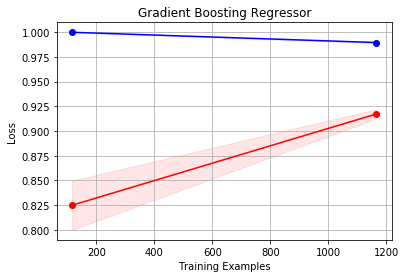

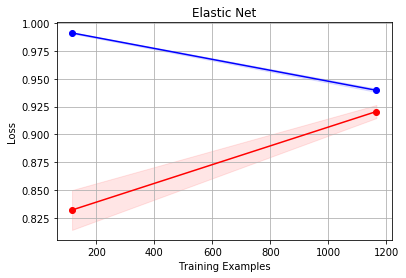

In [61]:
pl = plot_loss_curves(best_gbr_model, 'Gradient Boosting Regressor', train, target)
pl = plot_loss_curves(best_en_model, 'Elastic Net', train, target)

Ensemble method (Voting Regressor in order to predict final sale price)

In [63]:
#Fit the average from these two models above
pred_model = Model_Average(models = [best_gbr_model, best_en_model])
pred_model.fit(train, target)

Model_Average(models=[GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                criterion='friedman_mse',
                                                init=None, learning_rate=0.05,
                                                loss='huber', max_depth=4,
                                                max_features='sqrt',
                                                max_leaf_nodes=None,
                                                min_impurity_decrease=0.0,
                                                min_impurity_split=None,
                                                min_samples_leaf=1,
                                                min_samples_split=10,
                                                min_weight_fraction_leaf=0.0,
                                                n_estimators=1000,
                                                n_iter_no_change=None,
                                                presort='d

In [64]:
#Make sales price predictions
sales_price = pred_model.predict(test)

#Create results csv file
results = pd.DataFrame(Resulting_Id)

#Need to convert sales price back to actual sales numbers, so use np.expm1 which mathematically makes sales 
#price the same format
results['SalePrice'] = np.expm1(sales_price)

results.columns = ['Id', 'SalePrice']

results.to_csv('Sales_Price_Pred.csv', index = False)

In [65]:
results

,Id,SalePrice
0,1461,125262.385953
1,1462,160492.212083
2,1463,188880.319135
3,1464,200382.173277
4,1465,190901.131449
...,...,...
1454,2915,85481.074020
1455,2916,83405.373966
1456,2917,166373.206821
1457,2918,117534.051772
